# Anomalous sound detection in industrial pumps

## TOC
- [Introduction](#intro)
- [State of the art](#art)
- [Project](#project)
- [Dataset](#dataset)
- [Methodology](#metho)
- [Summary](#summary)
- [Conclusions](#conclusions)
- [Appendix](#appendix)
    - [Docker images](#docker)
    - [Docker compose](#docker-compose)
    - [Tensorflow serving](#tf-serving)
    - [Streamlit](#streamlit)

## Introduction <a id='intro'></a>

In [1]:
import tensorflow_datasets as tfds

import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Anomalous sounds can indicate a fault in a piece of machinery, and early detection of them would prevent the propagation of damage. Because of that, the scientific machine learning community is putting a lot of attention on **anomalous sound detection (ASD)**. 

ASD is the task of identifying whether the sound emitted from an object is normal or anomalous. 

<img src="http://d33wubrfki0l68.cloudfront.net/268bbc4666654d6e5ef28c449067626fbfee7488/2ad7c/images/tasks/challenge2020/task2_unsupervised_detection_of_anomalous_sounds_for_machine_condition_monitoring_01.png" width="25%" height="25%" />

Anomaly detection techniques can be categorized as:. 
- **Supervised anomaly detection** requires the entire dataset to be labeled "normal" or "anomaly". This technique is a binary classification task. 
- **Semi-supervised anomaly detection** requires only data considered "normal" to be labeled. In this technique, the model will learn what "normal" data are like. 
- **Unsupervised anomaly detection** involves unlabeled data. In this technique, the model will learn which data is "normal" and "anomaly".

## State of the art <a id='art'></a>

The paper [Anomalous Sound Detection with Machine Learning: A Systematic Review](https://www.arxiv-vanity.com/papers/2102.07820/) shows that the ToyADMOS, MIMII, and Mivia datasets, the Mel-frequency cepstral coefficients (MFCC) method for extracting features, the Autoencoder (AE) and Convolutional Neural Network (CNN) models of ML, the AUC and F1-score evaluation methods were most cited.

In [2]:
state_art_df = pd.read_csv("https://raw.githubusercontent.com/xiaoxi-david/malfunctioning-machines/main/development/jupyter/csv/state_art.csv")

def show_most_popular(col: str, n: int):
    """
    Clean, split and upper the strings 
    of the column col to make a list 
    with the n most popular strings.
    """
    return (
        state_art_df[col]
        .str.replace(r"( \[\d{1,2}\]|and|,$)", "")
        .str.split(",", expand=True)
        .melt()["value"]
        .str.upper()
        .str.strip()
        .value_counts()
        .head(n)
    )

The three most cited datasets were: [ToyADMOS](https://www.arxiv-vanity.com/papers/1908.03299/), [MIMII](https://www.arxiv-vanity.com/papers/1909.09347/), and [Mivia](https://mivia.unisa.it/datasets/audio-analysis/mivia-audio-events/). 
- The **ToyADMOS** dataset is a machine operating sound dataset that has approximately 540 hours of normal sound and approximately 12,000 hours of anomalous sound. ToyADMOS was designed to detect audio anomalies in research involving machine operation. 
- The **MIMII** dataset is a data set for investigation and inspection of defective industrial machines. It contains the sounds generated from four types of industrial machines (valves, pumps, fans and slide rails).
- The **Mivia** dataset is an audio dataset composed of 6,000 events considered to be vigilance (glass break, shots and screams).

In [3]:
show_most_popular("Dataset", 5)

OWN DATASET      10
TOYADMOS          8
MIMII             8
MIVIA DATASET     4
TUT DATASET       4
Name: value, dtype: int64

The main methods of extracting features were: [Mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), Log-Mel Energy, and Mel-spectrogram

In [4]:
show_most_popular("Audio Features", 5)

MFCC                10
LOG-MEL ENERGIES     7
MEL-SPECTROGRAM      5
ZCR                  4
DWT                  3
Name: value, dtype: int64

The two most popular machine learning techniques were: the [Autoencoder (AE)](https://en.wikipedia.org/wiki/Autoencoder) and the [Convolutional Neural Network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network). 

In [5]:
show_most_popular("ML Model", 5)

AE               7
ONE-CLASS SVM    5
CAE              4
CNN              4
WAVENET          3
Name: value, dtype: int64

The most used metrics were: 
- **AUC-ROC** is a performance evaluation that involves classification problems with thresholds. AUC represents a degree of separability and ROC is a probability curve.
The higher the AUC, the better the model for predicting a particular class. 
- **F1-score** measures the accuracy of an ML model. It is widely used in classification.

In [6]:
show_most_popular("Evaluation Method", 5)

ROC-AUC     19
F1-SCORE    12
ACCURACY     6
ROC-PAUC     5
ER           5
Name: value, dtype: int64

## Project <a id='project'></a>

For this project, I will use the [development dataset](https://zenodo.org/record/3678171) of pumps from the 2nd task of the [2020 DCASE Challenge](http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds) 

I use only audios from one machine (pump) because I don't have access to an NVIDIA GPU to reduce manipulation and training times.

## Dataset <a id='dataset'></a>

The dataset of this project is the [development dataset](https://zenodo.org/record/3678171) of pumps from the second task of the [2020 DCASE Challenge](http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds), a simplified version of the [MIMII](https://www.arxiv-vanity.com/papers/1909.09347/) dataset (audio files have only one channel instead of eight channels). 

In [7]:
import pump

data_dir = "../dataset"

(train, test), info = tfds.load(
    "pump",
    split=["train", "test"],
    data_dir=data_dir,
    with_info=True,
)

To speed up the training and manipulation of the audio samples, I have transformed the [development dataset](https://zenodo.org/record/3678171) of pumps from the second task of the [2020 DCASE Challenge](http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds) into a [Tensorflow dataset](https://www.tensorflow.org/datasets/overview). The original dataset of pumps has two folders (train and test) and filenames explain whether the audio sample is normal or anomaly and which machine it belongs to.

My Tensorflow dataset has the following information:
- **audio** holds the values of the audio file. Audios last 10 seconds and were recorded at 16kHz with a resolution of 16 bits
- **audio/id** is the id number of the audio
- **audio/machine** is the number of the pump (00, 02, 04, 06)
- **audio/split** shows the folders where the file comes from (train or test)
- **label** shows whether the sound is normal or anomaly

In [8]:
print(info.features)

FeaturesDict({
    'audio': Audio(shape=(160000,), dtype=tf.int64),
    'audio/id': Text(shape=(), dtype=tf.string),
    'audio/machine': Text(shape=(), dtype=tf.string),
    'audio/split': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [9]:
def print_plot(audio_sample, color):
    y = list(audio_sample)[0]["audio"].numpy() / 2**15
    sr = 16_000

    fig, ax = plt.subplots(1, 4, figsize=(24, 2))

    librosa.display.waveplot(y, sr=sr, ax=ax[0], color=color)
    ax[0].set(title=f"Waveplot")
    ax[0].set_ylim([-0.1, 0.1])

    S = np.abs(librosa.stft(y))
    D = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax[1])
    ax[1].set(title=f"Linear-frequency power spectrogram")
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

    img = librosa.display.specshow(D, y_axis='log', sr=sr, x_axis='time', ax=ax[2])
    ax[2].set(title='Log-frequency power spectrogram')
    fig.colorbar(img, ax=ax[2], format='%+2.0f dB')  

    M = librosa.feature.melspectrogram(S=S**2, sr=sr)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', sr=sr, fmax=8000, ax=ax[3])
    ax[3].set(title=f"Mel spectrogram")
    fig.colorbar(img, ax=ax[3], format='%+2.0f dB')

To have a better understanding of the audio samples, we can listen to anomaly and normal audios and see some of the their main audio features (waveplots, spectograms and mel-spectrograms).

audio audio/id audio/machine  \
0  [-366, -623, -682, -742, -733, -683, -590, -53...  b'0309'         b'02'   

   audio/split  label  
0            0      0

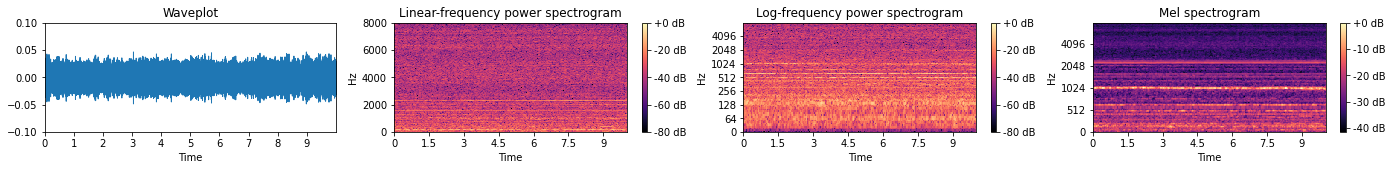

In [10]:
audio_sample = train.filter(lambda x: x["label"] == 0).shuffle(128).take(1)
print_plot(audio_sample, "tab:blue")
tfds.as_dataframe(audio_sample, info) 

audio audio/id audio/machine  \
0  [-278, -239, -295, 401, 244, 246, 553, 451, 46...  b'0089'         b'00'   

   audio/split  label  
0            1      0

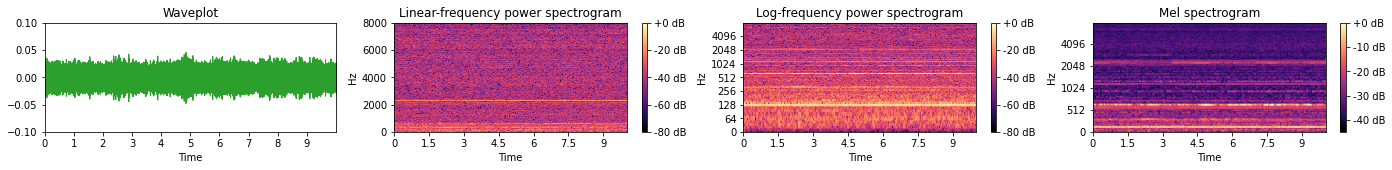

In [11]:
audio_sample = test.filter(lambda x: x["label"] == 0).shuffle(128).take(1)
print_plot(audio_sample, "tab:green")
tfds.as_dataframe(audio_sample, info) 

audio audio/id audio/machine  \
0  [-132, 139, 182, 772, 877, 1083, 544, 370, 777...  b'0096'         b'02'   

   audio/split  label  
0            1      1

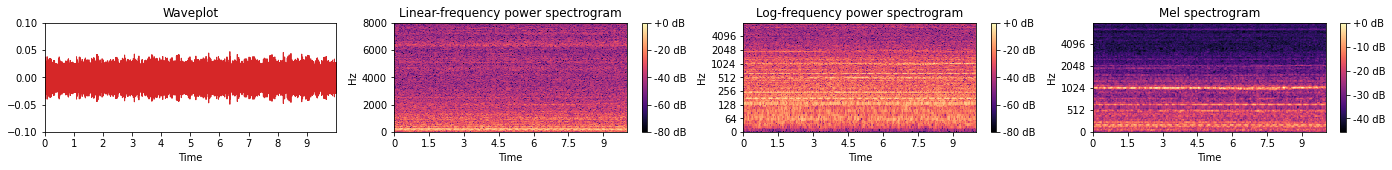

In [12]:
audio_sample = test.filter(lambda x: x["label"] == 1).shuffle(128).take(1)
print_plot(audio_sample, "tab:red")
tfds.as_dataframe(audio_sample, info) 

This pivot table shows the number of audios per split (train/test), machine_id (00,02,04,06) and label (normal/anomaly).

In [13]:
filenames_df = pd.read_csv("https://raw.githubusercontent.com/xiaoxi-david/malfunctioning-machines/main/development/jupyter/csv/filenames.csv")

machines_df = (
    filenames_df["filename"]
    .str.extract(r"(train|test).(normal|anomaly)_id_(\d{2})_\d{4}(\d{4})", expand=True)
    .rename(columns={0: "split", 1: "label", 2: "machine_id", 3: "audio_id"})
)

dct_types = {
    "split": "category",
    "label": "category",
    "machine_id": "category",
    "audio_id": "category",
}
machines_df = machines_df.astype(dct_types)

(
    machines_df
    .filter(["machine_id", "split", "label", "audio_id"])
    .pivot_table(
        values="audio_id",
        index=["machine_id"],
        columns=["split","label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
)

split         test         train
label      anomaly normal normal
machine_id                      
00             143    100    906
02             111    100    905
04             100    100    602
06             102    100    936

This dataset is suitable for *semi-supervised anomaly detection* because the train split has only normal audios and the test split contains normal and anomaly audios.

## Metodology <a id='metho'></a>

Although this dataset is only suitable for semi-supervised anomaly detectors, we can practide supervised anomaly detection with the test data.

- Notebook 5 and 6 shows to create supervised anomaly detectors using CNNs.
- Notebook 7, 8 and 9 shows to create semi-supervised anomaly detectors using AEs.

I use [Tensorflow](https://www.tensorflow.org), [Tensorboard](https://www.tensorflow.org/tensorboard/) and [Tensorflow serving](https://www.tensorflow.org/tfx/guide/serving) to solve the problem.

A popular approach in deep learning-based anomaly detection is to build a deep learning model, Autoencoder, to reduce the dimensionality of the data, and then reconstruct the input sample. 
An autoencoder belongs to a family of machine learning models, called neural networks, and more specifically deep neural networks. An autoencoder consists of an encoder, and a decoder.

## Conclusions <a id='conclusions'></a>

Train a semi-supervised anomaly detector is much more difficult than train a supervised anomaly detector because common guidelines for supervised machine learning don't apply to semi-supervised machine learning.

## Appendix <a id='appendix'></a>

### Docker images <a id='docker'></a>

To ensure the reproducibility of my code, I use four Docker images:
- **development_tensorboad**: the image for Tensorboard. The Dockrefile installs Tensorboard package in a 3.8 Python Docker image.
- **development_notebook**: the image for the Jupyter notebooks. The Dockerfile installs the required packages in a 3.7 Python Docker image. 
- **production_frontend**: the image for the Streamlit app. The Dockerfile installs Streamlit package in a 3.8 Python Docker image.
- **tensorflow/serving**: a Tensorflow serving Docker image from Docker hub. 

![Docker images](docker-images.png)

The Docker image for the Jupyter notebooks is different from the Docker image for Tensorboard and Streamlit because the wordcloud package wheel is not available for Python 3.8.

### Docker compose <a id='docker-compose'></a>

To run the required containers for production and development environment at the same time, I have created two Docker compose files, one for each environment.
- **Development** Docker compose file runs the Docker container for the Jupyter notebooks and Tensorboard and mounts several volumes for the notebooks.

- **Production** Docker compose file runs the Docker image for Streamlit and Tensorflow serving, creates a network to connect them and mounts several volumes for the source code of the app and the Tensorflow models for the Tensorflow serving.

### Tensorflow serving <a id='tf-serving'></a>

Tensorflow serving knows the name of the models and where to find the files from the *models.config* file. 

### Streamlit <a id='streamlit'></a>

I will put in production only the supervised anomaly detectors (from notebooks 5 and 6) because any of the three semi-supervised anomaly detectors (from notebooks 7, 8 and 9) work very poor. 

